# ***Causal Learning Tutorial - CelebA***

Author:
        
        PARK, JunHo, junho@ccnets.org

        
        KIM, JeongYoong, jeongyoong@ccnets.org
        
    COPYRIGHT (c) 2024. CCNets. All Rights reserved.


### **1. Import the Libraries**

In [1]:
import time
import random
import numpy as np

import torch
from torch import nn
import torch.utils.data
import torch.optim as optim
from torchvision import transforms
import torchvision.utils as vutils
import torchvision.datasets as dset

from IPython import display
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections.abc import Iterable

### **2. Basic Settings**

In [2]:
# set random seed for reproducibility
def set_random_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    return

set_random_seed(0)

### **3. Load Dataset**

#### 3-1. CelebA Dataset

The CelebA (CelebFaces Attributes Dataset) is a large-scale face attributes dataset widely used in facial recognition research. It includes 202,599 face images of 10,177 celebrities, each annotated with 40 attribute labels and 5 landmark locations. This dataset is extensively utilized in various computer vision research fields, particularly for facial recognition tasks.

##### Dataset Features:
- **Number of Images**: 202,599
- **Number of Celebrities**: 10,177
- **Number of Attributes**: 40 facial attributes
- **Landmarks**: 5 landmark locations per image

CelebA is particularly useful for studies in facial recognition, facial attribute detection, landmark localization, and attribute-based image retrieval. The diversity and size of the dataset make it suitable for training complex facial recognition models.

##### Licensing and More Information:
The CelebA dataset is available under a license that permits its use for academic and non-commercial purposes. For detailed documentation and to access the dataset, please visit the [CelebA Dataset Docs](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).

In [3]:
n_img_sz = 128 # Image size
attribute_indices = torch.tensor([20, 31]) # Male, Smiling

trainset = dset.CelebA(root='../data/celeba', split = "train", transform=transforms.Compose([
                            transforms.Resize(n_img_sz), # Transformations include resizing the images to `n_img_sz`
                            transforms.CenterCrop(n_img_sz), # Center cropping to the same size
                            transforms.ToTensor(), # Converting the images to tensors,
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalizing the pixel values to have a mean and standard deviation of 0.5 across all channels.
                        ]), download= False)
testset = dset.CelebA(root='../data/celeba', split = "test", transform=transforms.Compose([
                            transforms.Resize(n_img_sz), # Transformations include resizing the images to `n_img_sz`
                            transforms.CenterCrop(n_img_sz), # Center cropping to the same size
                            transforms.ToTensor(), # Converting the images to tensors
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalizing the pixel values to have a mean and standard deviation of 0.5 across all channels.
                        ]), download= False)    

#### 3-2. Dataloader Functions

In [4]:
def get_Dataloader(trainset, batch_size, shuffle = False, num_workers = 0, collate = None):
    return torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle = shuffle, num_workers = num_workers, collate_fn=collate, drop_last=True)

def get_testloader(testset, batch_size, shuffle = False, num_workers = 0, collate = None):
    return torch.utils.data.DataLoader(testset, batch_size= batch_size, shuffle = shuffle, num_workers = num_workers, collate_fn=collate, drop_last=True)

#### 3-3. Custom Dataset Class

In [5]:
class CelebA(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    
    def __getitem__(self, index):
        X, y = self.dataset[index] # Get the image and label at the specified index
        y= torch.index_select(y.unsqueeze(0), 1, attribute_indices).squeeze(0) # Select specific attributes(Male, Smiling) for the label using a predefined list of indices
        return X, y # Return the image and the selected attributes
    
    def __len__(self):
        return len(self.dataset) # Return the size of the dataset
    
trainset = CelebA(trainset)
testset = CelebA(testset)

#### 3-4. Training Setup and Parameters

In [6]:
obs_shape=[3, n_img_sz, n_img_sz]
label_size = 2
explain_size = 256
batch_size = 32
selected_indices = [737, 1518, 390, 607] # selected people's images

num_epoch = 5
learning_rate = 2e-4
total_iters = (len(trainset)//batch_size) * num_epoch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### **4. Custom Style Gan Classes**

##### This notebook demonstrates how to customize StyleGAN components, utilizing the discriminator as both the explainer and reasoner, and
##### the generator as the producer in a causal cooperative network.

In [7]:
class Discriminator(nn.Module):
    def __init__(self, output_size, num_channels = 3, channel_multiplier=64):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(num_channels, channel_multiplier, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(channel_multiplier, channel_multiplier * 2, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(channel_multiplier * 2, channel_multiplier * 4, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(channel_multiplier * 4, channel_multiplier * 8, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.AdaptiveAvgPool2d(1),

            nn.Flatten(),
            nn.Linear(channel_multiplier * 8 * 1 * 1, output_size),
        )

    def forward(self, img):
        return self.main(img)

class ConditionStyleMod(nn.Module):
    def __init__(self, latent_dim, condition_dim, channels):
        super().__init__()
        self.lin = nn.Linear(latent_dim + condition_dim, channels * 2)

    def forward(self, x, latent, condition):
        style = self.lin(torch.cat([latent, condition], dim=1))
        scale = style[:, :x.size(1)].unsqueeze(2).unsqueeze(3)
        shift = style[:, x.size(1):].unsqueeze(2).unsqueeze(3)
        return x * (scale + 1) + shift

class ConditionConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, latent_dim, condtion_dim, kernel_size, padding):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding)
        self.style1 = ConditionStyleMod(latent_dim, condtion_dim, out_channels)
        self.style2 = ConditionStyleMod(latent_dim, condtion_dim, out_channels)
        self.noise1 = nn.Parameter(torch.zeros(1, out_channels, 1, 1))
        self.noise2 = nn.Parameter(torch.zeros(1, out_channels, 1, 1))
        self.act = nn.LeakyReLU(0.2)

    def forward(self, x, latent, condition):
        x = self.conv1(x)
        rand1 = torch.randn_like(x)
        x = x + self.noise1 * rand1
        x = self.act(x)
        x = self.style1(x, latent, condition)
        
        x = self.conv2(x)
        rand2 = torch.randn_like(x)
        x = x + self.noise2 * rand2
        x = self.act(x)
        x = self.style2(x, latent, condition)
        return x

class ConditionalGenerator(nn.Module):
    def __init__(self, condition_dim, z_dim, channel_multiplier=64):
        super().__init__()

        self.initial = nn.Parameter(torch.randn(1, channel_multiplier, 4, 4))
        self.style1 = ConditionStyleMod(z_dim, condition_dim, channel_multiplier)
        self.blocks = nn.ModuleList([
            ConditionConvBlock(channel_multiplier, channel_multiplier, z_dim, condition_dim, 3, 1),
            ConditionConvBlock(channel_multiplier, channel_multiplier, z_dim, condition_dim, 3, 1),
            ConditionConvBlock(channel_multiplier, channel_multiplier, z_dim, condition_dim, 3, 1),
            ConditionConvBlock(channel_multiplier, channel_multiplier, z_dim, condition_dim, 3, 1),
            ConditionConvBlock(channel_multiplier, channel_multiplier, z_dim, condition_dim, 3, 1),
        ])
        self.to_rgb = nn.Sequential(
            nn.Conv2d(channel_multiplier, 3, 1),
        )

    def forward(self, condition, style):
        batch_size = style.shape[0]
        out = self.initial.expand(batch_size, -1, -1, -1)
        out = self.style1(out, style, condition)

        for block in self.blocks:
            out = nn.functional.interpolate(out, scale_factor=2, mode='nearest')
            out = block(out, style, condition)

        out = self.to_rgb(out)
        return out

### **5. Class Image Debugger**

In [9]:
class ImageDebugger:
    def __init__(self, dataset, label_size, device, selected_indices=None):
        self.device = device
        self.label_size = label_size
        self.selected_indices = selected_indices or []
        self.n_canvas_col = len(self.selected_indices)
        self.n_canvas_row = min(self.n_canvas_col, 4)
        self.display_images, self.display_labels = self.stack_selected_images_labels(dataset)
        self.canvas_image = self.create_canvas()
        
    def stack_selected_images_labels(self, dataset):
        images, labels = [], []
        for idx in self.selected_indices:
            img, lbl = dataset[idx]
            images.append(img.unsqueeze(0))
            labels.append(lbl.unsqueeze(0).type(torch.float))
        
        return torch.cat(images).to(self.device).float(), torch.cat(labels).to(self.device).float()

    def create_canvas(self):
        canvas = np.ones((n_img_sz * (self.n_canvas_row + 1), 
                          n_img_sz * (self.n_canvas_col + 1), 3))
        for i, image in enumerate(self.display_images):
            img = np.transpose(vutils.make_grid(image.detach().cpu().unsqueeze(0), padding=0, normalize=True).numpy(), (1, 2, 0))
            canvas[:n_img_sz, n_img_sz * (i + 1):n_img_sz * (i + 2)] = img
        return canvas

    def update_images(self):
        with torch.no_grad():
            explains = explainer(self.display_images)
            inferred_labels = reasoner(self.display_images, explains)
            for i in range(self.n_canvas_row):
                controlled_labels = self.display_labels[i:i + 1, :].clone().detach().expand_as(inferred_labels)
                generated_images = producer(controlled_labels, explains).cpu()
                self.place_on_canvas(generated_images, i)

    def place_on_canvas(self, images, row):
        img = np.transpose(vutils.make_grid(images[:self.n_canvas_col], padding=0, normalize=True).numpy(), (1, 2, 0))
        self.canvas_image[n_img_sz * (row + 1):n_img_sz * (row + 2), n_img_sz:] = img

    def display_image(self, figsize=(13, 13)):
        plt.figure(figsize=figsize)
        display.clear_output(wait=True)
        plt.imshow(self.canvas_image)
        plt.axis("off")
        labels = ["Female, No-smile", "Male, No-smile", "Female, Smile", "Male, Smile"]
        for i, label in enumerate(labels):
            plt.text(60, 128 * (i + 2) - 128 // 2, label, fontsize=12, va='center', ha='center')
        plt.show()


### **6. Causal Cooperative Network(CCNet)**

#### 6-1. Initialize Models

In [8]:
def init_weights(param_object):
    if isinstance(param_object, Iterable):
        for layer in param_object:
            if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
            else:
                pass

#### 6-2. Networks

In [10]:
class Explainer(nn.Module):
    def __init__(self, obs_shape, explain_size):
        super(Explainer, self).__init__()
        self.net = Discriminator(explain_size, num_channels=3) 
        self.apply(init_weights)

    def forward(self, x):
        e = self.net(x) 
        e = torch.sigmoid(e)
        return e
    
class Reasoner(nn.Module):
    def __init__(self, obs_shape, explain_size, label_size):
        super(Reasoner, self).__init__()
        self.obs_shape = obs_shape
        self.explain_size = explain_size
        self.total_product = torch.prod(torch.tensor(obs_shape[1:], dtype=torch.int)).item()
        self.net = Discriminator(label_size, num_channels=4) 
        self.apply(init_weights)
    
    def forward(self, obs, e):
        e = self._convert_explanation_to_input_shape(e)
        z = torch.cat([obs, e], dim=1)  # Concatenate along the channel dimension
        y = self.net(z) 
        y = torch.sigmoid(y)
        return y

    def _convert_explanation_to_input_shape(self, e):
        """ Convert the explanation vector to match the target image shape with the first dimension set to 1. """
        explain_shape = [1] + list(self.obs_shape[1:])  # Set first dim to 1, rest match target shape
        expanded_e = torch.cat([e.repeat(1, self.total_product//self.explain_size), torch.zeros_like(e[:, :self.total_product%self.explain_size])], dim = -1)  # Repeat to match the volume of target shape
        expanded_e = expanded_e.view(-1, *explain_shape)  # Reshape explanation vector to the new explain_shape
        return expanded_e

class Producer(nn.Module):
    def __init__(self, label_size, explain_size, obs_shape):
        super(Producer, self).__init__()
        self.net = ConditionalGenerator(condition_dim=label_size, z_dim=explain_size)
        self.apply(init_weights)

    def forward(self, labels, explains):
        x = self.net(condition = labels, style = explains) 
        x = torch.tanh(x)
        return x

In [11]:
explainer = Explainer(obs_shape, explain_size).to(device)
reasoner = Reasoner(obs_shape, explain_size, label_size).to(device)
producer = Producer(label_size, explain_size, obs_shape).to(device)

networks = [explainer, reasoner, producer] 

### **7. CCNet Training Parameters and Optimizers**

In [12]:
# Parameters
learning_rate = 0.001
decay_rate = 0.1
iteration_100k = 100000
gamma = pow(decay_rate, 1 / iteration_100k)

# Components setup
components = {
    'explainer': explainer.parameters(),
    'reasoner': reasoner.parameters(),
    'producer': producer.parameters()
}

# Optimizers and Schedulers
optimizers = {}
schedulers = {}

for name, parameters in components.items():
    optimizer = optim.Adam(parameters, lr=learning_rate, betas=(0.9, 0.999))
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
    optimizers[name] = optimizer
    schedulers[name] = scheduler

In [13]:
def update_step():
    # Update all optimizers
    for optimizer in optimizers.values():
        optimizer.step()
        optimizer.zero_grad()
    
    # Update all schedulers
    for scheduler in schedulers.values():
        scheduler.step()

### **8. CCNet Train**

#### 8.1 Training Print Functions

In [14]:
def print_iter(epoch, num_epoch, iters, len_dataloader, et):
    print('[%d/%d][%d/%d][Time %.2f]'
        % (epoch, num_epoch, iters, len_dataloader, et))

def print_train(losses, errors):
    print('--------------------Training Metrics--------------------')
    print('Inf: %.4f\tGen: %.4f\tRec: %.4f\tE: %.4f\tR: %.4f\tP: %.4f'
        % (losses['inference_loss'].mean(), losses['generation_loss'].mean(), losses['reconstruction_loss'].mean(), 
           errors['explainer_error'].mean(), errors['reasoner_error'].mean(), errors['producer_error'].mean()))

def print_lr():
    opt_explainer = optimizers['explainer']
    lr = opt_explainer.param_groups[0]['lr']
    print('Opt-{0} lr_ERP: {1}'.format(type(opt_explainer).__name__, lr))

def print_metrics(metrics):
    print('--------------------Test Metrics------------------------')
    for label_type, metric in metrics.items():
        text = (f'{label_type}: %.4f'
            % metric)
        print(text)
    print()

#### 8.2 Backward

In [15]:
def backwards(networks, network_errors):
    # Implementation details follow
    num_network = len(networks)
    # Temporarily disable gradient computation for all networks
    for network in networks:
        network.requires_grad_(False)        
        
    for net_idx, (network, error) in enumerate(zip(networks, network_errors)):
        # Enable gradient computation for the current network
        network.requires_grad_(True)
        # Zero out the gradient for all networks starting from the current network
        for n in networks[net_idx:]:
            n.zero_grad()
        # Decide whether to retain the computation graph based on the network and error index
        retain_graph = (net_idx < num_network - 1)
        # Apply the discounted gradients in the backward pass
        error.backward(retain_graph=retain_graph)
        # Prevent gradient updates for the current network after its errors have been processed
        network.requires_grad_(False)
        
    # Restore gradient computation capability for all networks for potential future forward passes
    for network in networks:
        network.requires_grad_(True)
    return

#### 8-3. Loss and Error Functions

In [16]:
def loss_fn(predict, target):
    batch_size = predict.size(0)
    discrepancy = (predict - target.detach()).abs()
    prediction_loss = discrepancy.view(batch_size, -1).mean(dim=-1)
    return prediction_loss

def error_fn(predict, target):
    discrepancy = (predict - target.detach()).abs()
    cooperative_error = discrepancy.mean(dim = 0) 
    return cooperative_error

#### 8-4. CCNet Train Models

In [17]:
def train_models(networks, observation, label, iters):
    # Set the models to training mode and perform the forward pass.
    for network in networks:
        network.train()
    ################################  Forward Pass  ################################################
    explain = explainer(observation)
    inferred_label = reasoner(observation, explain)
    
    # reset random seed for internal noise factor
    set_random_seed(iters)
    generated_observation = producer(label, explain)
    
    # reset random seed for internal noise factor
    set_random_seed(iters)
    reconstructed_observation = producer(inferred_label, explain.detach())

    ################################  Prediction Losses  ###########################################
    # Calculate prediction losses for inference, generation, and reconstruction.
    inference_loss = loss_fn(reconstructed_observation, generated_observation)
    generation_loss = loss_fn(generated_observation , observation)
    reconstruction_loss = loss_fn(reconstructed_observation, observation)

    ################################  Model Losses  ################################################
    # Calculate model errors based on the losses.
    explainer_error = error_fn(inference_loss + generation_loss, reconstruction_loss)
    reasoner_error = error_fn(reconstruction_loss + inference_loss, generation_loss)
    producer_error = error_fn(generation_loss + reconstruction_loss, inference_loss)

    ################################  Backward Pass  ###############################################
    # Perform the backward pass and update the models.
    backwards(
        [explainer, reasoner, producer], 
        [explainer_error, reasoner_error, producer_error]
        )
    ################################  Model Update  ###############################################
    # Update optimizers and schedulers, and reset the random seed.

    update_step()

    # Calculate and return the mean losses and errors.
    metrics = {
        "losses": 
            {
            "inference_loss" : inference_loss,
            "generation_loss" : generation_loss,
            "reconstruction_loss" : reconstruction_loss},
        "errors": 
            {
            "explainer_error" : explainer_error, 
            "reasoner_error" : reasoner_error, 
            "producer_error" : producer_error}
    }
    return metrics

### **9. CCNet Test Functions**

In [18]:
def set_evaluation_mode():
    for network in networks:
        network.eval()

def select_random_batch():
    dataloader = get_testloader(testset, batch_size)
    dataloader_list = list(dataloader)
    random_batch = random.choice(dataloader_list)
    source_batch, target_batch = map(lambda x: x.float().to(device), random_batch)
    return source_batch, target_batch

def compute_metrics(predicted, actual):
    metrics = {}
    classes = torch.unique(actual)
    precision_list, recall_list, f1_list = [], [], []

    for c in classes:
        TP = torch.sum((predicted == c) & (actual == c)).float()
        FP = torch.sum((predicted == c) & (actual != c)).float()
        FN = torch.sum((predicted != c) & (actual == c)).float()

        precision = TP / (TP + FP) if TP + FP > 0 else 0
        recall = TP / (TP + FN) if TP + FN > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1_score)

    metrics['accuracy'] = torch.mean((predicted == actual).float()).item()
    metrics['precision'] = torch.mean(torch.tensor(precision_list)).item()
    metrics['recall'] = torch.mean(torch.tensor(recall_list)).item()
    metrics['f1_score'] = torch.mean(torch.tensor(f1_list)).item()
    
    return metrics

def print_metrics(metrics):
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

def test(iters):
    set_random_seed(iters)
    set_evaluation_mode()
    source_batch, target_batch = select_random_batch()
    
    with torch.no_grad():
        e = explainer(source_batch)
        inferred_y = reasoner(source_batch, e)
    
    inferred_labels = torch.argmax(inferred_y, dim=1)
    actual_labels = torch.argmax(target_batch, dim=1)

    metrics = compute_metrics(inferred_labels, actual_labels)
    print_metrics(metrics)
    return metrics

### **10. CCNet Training Loop**

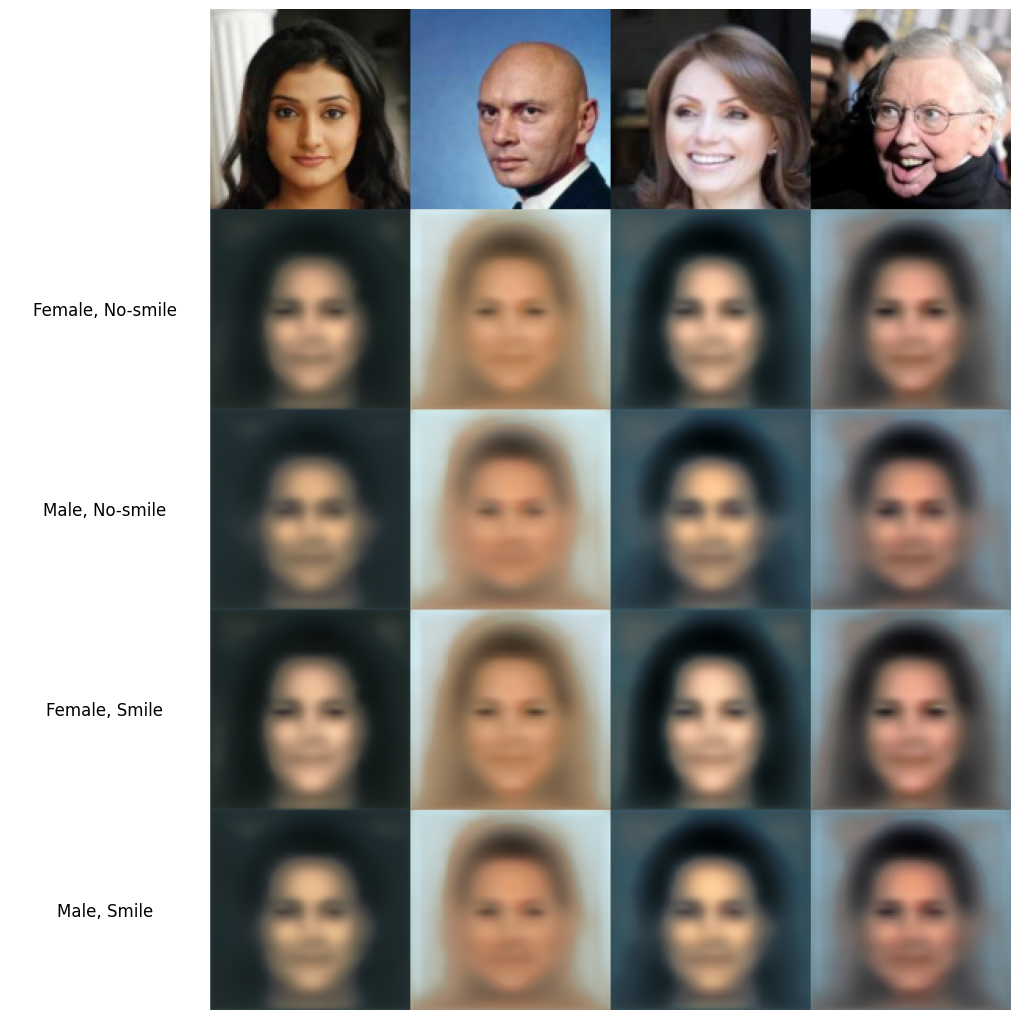

[0/5][1550/5086][Time 42.69]
Opt-Adam lr_ERP: 0.000964917093512568
--------------------Training Metrics--------------------
Inf: 0.0313	Gen: 0.3644	Rec: 0.3648	E: 0.0308	R: 0.0317	P: 0.6980


In [19]:
sum_losses, sum_errors = None, None
iters, cnt_checkpoints, cnt_print = 0, 0, 0
pvt_time = time.time()
num_checkpoints = 50
current_lrs = []
selected_indices = [737, 1518, 390, 607]
image_debugger = ImageDebugger(trainset, label_size, device, selected_indices=selected_indices)

pbar_epoch = tqdm(range(num_epoch), desc='Epochs', leave=False)
for epoch in pbar_epoch:
    dataloader = get_Dataloader(trainset, batch_size, shuffle=True)
    len_dataloader = len(dataloader)
    
    # Training loop over each batch
    pbar_iter = tqdm(dataloader, desc='Iterations', leave=False)
    for iters, (source_batch, target_batch) in enumerate(pbar_iter):

        set_random_seed(iters)
        state_trajectory, target_trajectory = source_batch.float().to(device), target_batch.float().to(device)
        
        causal_trainer_metrics = train_models(networks, state_trajectory, target_trajectory, iters)
        
        if cnt_checkpoints % num_checkpoints == 0 and cnt_checkpoints != 0:
            # =====process_checkpoint======
            image_debugger.update_images()
            image_debugger.display_image()

            cur_time = time.time()
            et = cur_time - pvt_time
            pvt_time = cur_time
            
            print_iter(epoch, num_epoch, iters, len_dataloader, et)
            print_lr()
            print_train(causal_trainer_metrics["losses"], causal_trainer_metrics["errors"])

            metrics = test(iters) 

            sum_losses, sum_errors, cnt_checkpoints = None, None, 0
            cnt_print += 1
            
            pbar_iter.display()
            pbar_epoch.display()

        iters += 1; cnt_checkpoints += 1
        total_iter = (epoch + 1) * iters
        
        time_cost = time.time() - pvt_time